In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import gridspec
import scipy
from src import utils, evaluation
import copy
import pickle
import scipy.stats

In [2]:
# Set tex formatting for plots
from matplotlib import rc
rc('font',**{'family':'serif','sans-serif':['Computer Modern Roman']})
rc('text', usetex=True)
#plt.rcParams["font.family"] = "serif"
#plt.rcParams["font.serif"] = ["Computer Modern Roman"]

In [3]:
# Set legend size
from matplotlib.font_manager import FontProperties
fontP = FontProperties()
fontP.set_size('medium')

### Auxiliary functions, colors

In [4]:
def jaccard_distance(A,B,p=None):
    A = set(A) if type(A) is not set else A
    B = set(B) if type(B) is not set else B
    return len(A & B) / len(A | B)

In [5]:
def hamming_distance(A,B,p):
    a = np.zeros(p)
    b = np.zeros(p)
    a[list(A)] = 1
    b[list(B)] = 1
    return scipy.spatial.distance.hamming(a, b)

In [46]:
def compute_trajectories_abcd(abcd_results, metric=jaccard_distance, estimate="weighted"):
    Trajectories = []
    for graph in abcd_results:
        _id, truth, _mec_size, runs = graph
        for posteriors in runs:
            # Trajectory of each run
            trajectory = []
            for (Parents, probs) in posteriors:
                distances = np.array(list(map(lambda parents: metric(truth, parents), Parents)))
                if estimate == "weighted":
                    weighted_metric = distances @ probs
                elif estimate == "max":
                    weighted_metric = distances[np.argmax(probs)]
                trajectory.append(weighted_metric)
            Trajectories.append(trajectory)
    return np.array(Trajectories)

In [47]:
def compute_entropies(abcd_results):
    Trajectories = []
    for graph in abcd_results:
        _id, _truth, _mec_size, runs = graph
        for posteriors in runs:
            # Entropy reduction for each run
            trajectory = []
            for (_Parents, probs) in posteriors:
                entropy = scipy.stats.entropy(probs)
                trajectory.append(entropy)
            Trajectories.append(trajectory)
    return np.array(Trajectories)

In [54]:
def mec_sizes(results):
    return list(map(lambda result: result[0], results))

In [36]:
def compute_trajectories_aicp(results, cases, metric=jaccard_distance):
    runs = len(results[0])
    N = len(results[0][0])
    P = len(results)

    no_ints = np.zeros((len(results), runs, N))
    all_trajectories = {}
    names = []
    for k, policy_runs in enumerate(results):
        name = policy_runs[0][0].policy
        print("Processing results for %s policy" % name, end="")
        names.append(name)
        trajectories = []
        for i,run_results in enumerate(policy_runs):
            no_ints[k, i,:] = list(map(lambda result: len(result.interventions()), run_results))
            for j, result in enumerate(run_results):
                estimates = list(map(lambda step: step[0], result.history[0::])) + [result.estimate]
                trajectory = list(map(lambda estimate: metric(cases[j].truth[0], estimate, cases[j].sem.p), estimates))
                trajectories.append(trajectory)
        all_trajectories[name] = np.array(trajectories)
        print(" done")
    return all_trajectories, N, P, runs, names, no_ints

In [24]:
# Helper functions for processing AICP results
def load_experiments(filename):
    f = open(filename, "rb")
    results = pickle.load(f)
    return results[0], results[1::]

def merge_runs(old, new, min_merge=False):
    if len(old) == len(new) or (len(old) < len(new) and min_merge):
        for i in range(len(old)):
            old[i] += new[i].copy()
    else:
        raise Exception("Cannot merge")
    return old

# Main function
def load_results(filenames, alg, same_graphs=False):
    # Load results for ABCD
    if alg == "abcd":
        results = []
        processed = []
        for filename in filenames:
            results += pickle.load(open(filename, "rb"))
        G = int(len(results) / len(filenames)) if same_graphs else len(results)
        # Turn posteriors into a list of runs
        for i in range(G):
            (mec0, truth0, target0, posteriors0) = results[i]
            runs = [posteriors0]
            # If filenames correspond to different runs, merge results
            if same_graphs:
                for j in range(1,len(filenames)):
                    (mec, truth, target, posteriors) = results[i+j*G]                    
                    assert mec == mec0 and truth0 == truth and target0 == target
                    runs.append(posteriors)
            processed += [(mec0, truth0, target0, runs)]
        print("\nLoaded a total of %d graphs with %d runs" % (G, len(runs)))
        return processed
    # Load results for AICP
    elif alg == "aicp":
        cases, results = load_experiments(filenames[0])
        for filename in filenames[1::]:
            print("Loading %s" % filename)
            new_cases, new_results = load_experiments(filename)
            cases += new_cases
            for k in range(len(results)):
                results[k] = merge_runs(results[k], new_results[k])
        print("\nLoaded a total of %d graphs with %d runs each" % (len(results[0][0]), len(results[0])))
    return cases, results

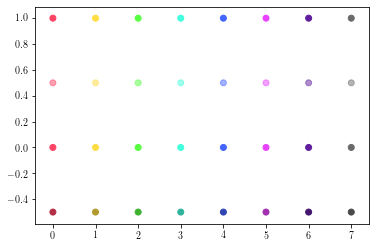

In [25]:
# Colors
def to_rgb(H, b=1, a=1):
    RGBa = []
    for h in H:
        h = h.lstrip("#")
        RGBa.append(tuple(int(h[i:i+2], 16) / 256 * b for i in (0, 2, 4)) + (a,))
    return np.array(RGBa)

cmap = matplotlib.cm.get_cmap('tab20')
base = ["#ff4365", "#ffdd43", "#59ff43", "#43ffdd", "#4365ff", "#e943ff", "#601e9e", "#6a6a6a"]#np.array([cmap(i) for i in range(2,20)])
plt.scatter(np.arange(len(base)), np.ones(len(base)), c = base)
#base = [base[i] for i in [0,1,3]]
colors = to_rgb(base)
colorsa = to_rgb(base, a=0.5)
colorsb = to_rgb(base, b=0.7)
plt.scatter(np.arange(len(colors)), np.zeros(len(colors)), c = colors)
plt.scatter(np.arange(len(colors)), np.ones(len(colors))*0.5, c = colorsa)
plt.scatter(np.arange(len(colors)), np.ones(len(colors))*-0.5, c = colorsb)

### Load and process data

#### Load ABCD results

In [39]:
filenames_abcd_1000 = [
    "experiments/pp_1586412657_n_samples:500_n_batches:50_max_interventions:1_strategy:entropy_intervention_strength:2.0_starting_samples:1000_target:0_intervention_type:gauss_target_allowed:True.pickle",
    "experiments/pp_1586845410_n_samples:500_n_batches:50_max_interventions:1_strategy:entropy_intervention_strength:2.0_starting_samples:1000_target:0_intervention_type:gauss_target_allowed:True.pickle"
]

filenames_abcd_100 = ["experiments/pp_1586332067_n_samples:500_n_batches:50_max_interventions:1_strategy:entropy_intervention_strength:2.0_starting_samples:100_target:0_intervention_type:gauss_target_allowed:True.pickle"]

filenames_abcd_50 = [
    "experiments/pp_1586357687_n_samples:500_n_batches:50_max_interventions:1_strategy:entropy_intervention_strength:2.0_starting_samples:50_target:0_intervention_type:gauss_target_allowed:True.pickle",
    "experiments/pp_1586846548_n_samples:500_n_batches:50_max_interventions:1_strategy:entropy_intervention_strength:2.0_starting_samples:50_target:0_intervention_type:gauss_target_allowed:True.pickle",
    "experiments/pp_1586849797_n_samples:500_n_batches:50_max_interventions:1_strategy:entropy_intervention_strength:2.0_starting_samples:50_target:0_intervention_type:gauss_target_allowed:True.pickle"
]

In [55]:
results_abcd_1000 = load_results(filenames_abcd_1000, "abcd", True)
Trajectories_abcd_1000 = compute_trajectories_abcd(results_abcd_1000, estimate="weighted")
Entropies_abcd_1000 = compute_entropies(results_abcd_1000)
mec_sizes1000 = mec_sizes(results_abcd_1000)

results_abcd_100 = load_results(filenames_abcd_100, "abcd", True)
Trajectories_abcd_100 = compute_trajectories_abcd(results_abcd_100, estimate="weighted")
Entropies_abcd_100 = compute_entropies(results_abcd_100)

results_abcd_50 = load_results(filenames_abcd_50, "abcd", True)
Trajectories_abcd_50 = compute_trajectories_abcd(results_abcd_50, estimate="weighted")
Entropies_abcd_50 = compute_entropies(results_abcd_50)


Loaded a total of 100 graphs with 2 runs

Loaded a total of 100 graphs with 1 runs

Loaded a total of 100 graphs with 3 runs


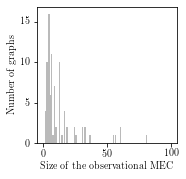

In [67]:
plt.figure(figsize=(2.5, 2.5))
mec_sizes1000
plt.hist(mec_sizes1000, np.arange(100), rwidth=1, align='mid', color="#BABABA")#colorsb[2])
plt.xlabel("Size of the observational MEC")
plt.ylabel("Number of graphs")
plt.savefig("figures/mec_sizes.pdf", bbox_inches='tight')

#### Load A-ICP results

In [29]:
filenames_aicp_1000lvl001 = ["experiments/results_1586316078_n_workers:-1_batch_size:20000_G:4_runs:16_finite:True_max_iter:50_n:10_n_obs:1000_alpha:0.001_tag:apr7_10_1000l2_load_dataset:dataset_3_abcd:True.pickle"]
filenames_aicp_1000lvl0002 = ["experiments/results_1586317669_n_workers:-1_batch_size:20000_G:4_runs:16_finite:True_max_iter:50_n:10_n_obs:1000_alpha:0.0002_tag:apr7_10_1000l1_load_dataset:dataset_3_abcd:True.pickle"]
filenames_aicp_100 = ["experiments/results_1586319650_n_workers:-1_batch_size:20000_G:4_runs:16_finite:True_max_iter:50_n:10_n_obs:100_alpha:0.0002_tag:apr7_10_100_load_dataset:dataset_3_abcd:True.pickle"]
filenames_aicp_50 = ["experiments/results_1586324804_n_workers:-1_batch_size:20000_G:4_runs:16_finite:True_max_iter:50_n:10_n_obs:50_alpha:0.0002_tag:apr7_10_50_load_dataset:dataset_3_abcd:True.pickle"]

In [30]:
cases, results_aicp_1000 = load_results(filenames_aicp_1000lvl0002, "aicp")
Trajectories_aicp_1000 = compute_trajectories_aicp(results_aicp_1000, cases)[0]

cases, results_aicp_100 = load_results(filenames_aicp_100, "aicp")
Trajectories_aicp_100 = compute_trajectories_aicp(results_aicp_100, cases)[0]

cases, results_aicp_50 = load_results(filenames_aicp_50, "aicp")
Trajectories_aicp_50 = compute_trajectories_aicp(results_aicp_50, cases)[0]


Loaded a total of 100 graphs with 16 runs each
Processing results for random policy done
Processing results for e + r policy done

Loaded a total of 100 graphs with 16 runs each
Processing results for random policy done
Processing results for e + r policy done

Loaded a total of 100 graphs with 16 runs each
Processing results for random policy done
Processing results for e + r policy done


### Plot A: Metric distributions vs. intervention number

In [49]:
Trajectories_abcd_1000.shape

(200, 51)

In [43]:
Trajectories_aicp_1000["random"].shape

(1600, 51)

In [32]:
def plot_trajectories_dist(Trajectories, axes, color=None):
    bplot = axes.boxplot(Trajectories,
                         vert=True,  # vertical box alignment
                         patch_artist=True,
                         medianprops = {'color': 'black'})
    if color is not None:
        for i,patch in enumerate(bplot['boxes']):
            patch.set_facecolor(color)

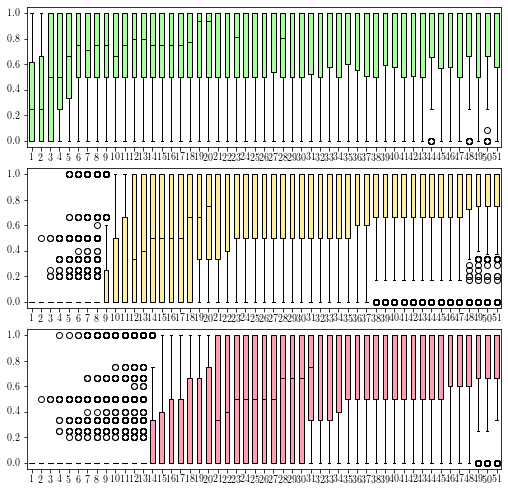

In [50]:
gs = gridspec.GridSpec(3, 1, wspace=0.10, hspace=0.15)
plt.figure(figsize=(8.5,8.5))

plt.subplot(gs[0])
ax = plt.gca()
plot_trajectories_dist(Trajectories_abcd_1000, ax, color=colorsa[2])
plt.subplot(gs[1])
ax = plt.gca()
plot_trajectories_dist(Trajectories_aicp_1000["e + r"], ax, color=colorsa[1])

plt.subplot(gs[2])
ax = plt.gca()
plot_trajectories_dist(Trajectories_aicp_1000["random"], ax, color=colorsa[0])

### Plot B: Metric mean vs. intervention number

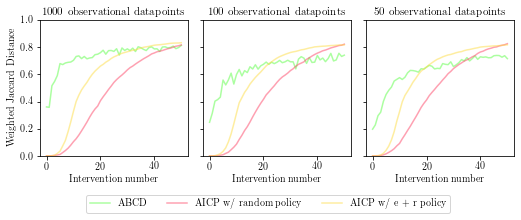

In [69]:
gs = gridspec.GridSpec(1, 3, wspace=0.10, hspace=0.15)
plt.figure(figsize=(8.5,2.5))

ylim = [0,1]

# Plot for 1000 initial samples
plt.subplot(gs[0])
ax = plt.gca()
ax.plot(Trajectories_abcd_1000.mean(axis=0), c=colorsa[2], label="ABCD", linewidth=1.5)
ax.plot(Trajectories_aicp_1000["random"].mean(axis=0), c=colorsa[0], label="AICP w/ random policy", linewidth=1.5)
ax.plot(Trajectories_aicp_1000["e + r"].mean(axis=0), c=colorsa[1], label="AICP w/ e + r policy", linewidth=1.5)
plt.xlabel("Intervention number")
plt.ylabel("Weighted Jaccard Distance")
ax.text(0.5,1.04,"1000 observational datapoints", transform=ax.transAxes, fontsize=11, ha="center")
plt.ylim(ylim)

# Plot for 100 initial samples
plt.subplot(gs[1])
ax = plt.gca()
ax.plot(Trajectories_abcd_100.mean(axis=0), c=colorsa[2], label="ABCD", linewidth=1.5)
ax.plot(Trajectories_aicp_100["random"].mean(axis=0), c=colorsa[0], label="AICP w/ random policy", linewidth=1.5)
ax.plot(Trajectories_aicp_100["e + r"].mean(axis=0), c=colorsa[1], label="AICP w/ e + r policy", linewidth=1.5)
plt.xlabel("Intervention number")
ax.set_yticklabels([])
ax.text(0.5,1.04,"100 observational datapoints", transform=ax.transAxes, fontsize=11, ha="center")
plt.ylim(ylim)

# Plot for 50 initial samples
plt.subplot(gs[2])
ax = plt.gca()
ax.plot(Trajectories_abcd_50.mean(axis=0), c=colorsa[2], label="ABCD", linewidth=1.5)
ax.plot(Trajectories_aicp_50["random"].mean(axis=0), c=colorsa[0], label="AICP w/ random policy", linewidth=1.5)
ax.plot(Trajectories_aicp_50["e + r"].mean(axis=0), c=colorsa[1], label="AICP w/ e + r policy", linewidth=1.5)
plt.xlabel("Intervention number")
ax.set_yticklabels([])
ax.text(0.5,1.04,"50 observational datapoints", transform=ax.transAxes, fontsize=11, ha="center")
plt.ylim(ylim)

ax.legend(prop=fontP, ncol=5, bbox_to_anchor=(0.6, -.25))

plt.savefig("figures/abcd_vs_aicp.pdf", bbox_inches='tight')

### Plot C: Mean entropy of posterior for ABCD

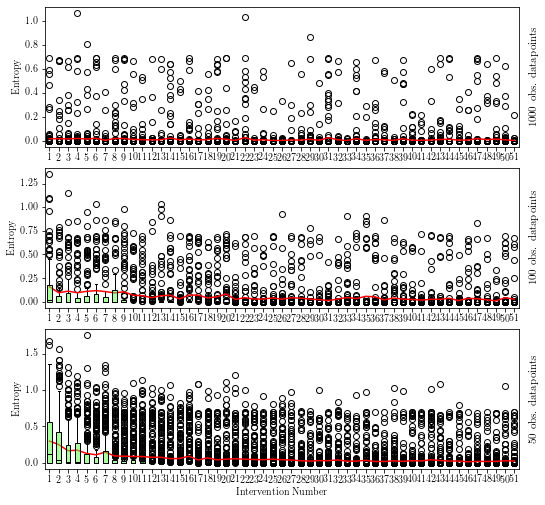

In [52]:
gs = gridspec.GridSpec(3, 1, wspace=0.10, hspace=0.15)
plt.figure(figsize=(8.5,8.5))

# For 1000 initial samples
plt.subplot(gs[0])
ax = plt.gca()
plot_trajectories_dist(Entropies_abcd_1000, ax, color=colorsa[2])
mean = Entropies_abcd_1000.mean(axis=0)
plt.ylabel("Entropy")
ax.text(1.02,0.5,"1000 obs. datapoints", transform=ax.transAxes, fontsize=11, va="center", rotation=90)
ax.plot(np.arange(1,52), mean, color="red")

# For 100 initial samples
plt.subplot(gs[1])
ax = plt.gca()
plot_trajectories_dist(Entropies_abcd_100, ax, color=colorsa[2])
mean = Entropies_abcd_100.mean(axis=0)
plt.ylabel("Entropy")
ax.text(1.02,0.5,"100 obs. datapoints", transform=ax.transAxes, fontsize=11, va="center", rotation=90)
ax.plot(np.arange(1,52), mean, color="red")

# For 50 initial samples
plt.subplot(gs[2])
ax = plt.gca()
plot_trajectories_dist(Entropies_abcd_50, ax, color=colorsa[2])
mean = Entropies_abcd_50.mean(axis=0)
plt.ylabel("Entropy")
ax.text(1.02,0.5,"50 obs. datapoints", transform=ax.transAxes, fontsize=11, va="center", rotation=90)
plt.xlabel("Intervention Number")
ax.plot(np.arange(1,52), mean, color="red")